In [1]:
import sys
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
import torch
from src.datamodule import ClayDataModule
from src.model_clay_v1 import ClayMAEModule

/opt/conda/envs/claymodel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ckpt = "../checkpoints/v0.5.3/mae_v0.5.3_epoch-08_val-loss-0.3150.ckpt" # patch 8 x 8
model = ClayMAEModule.load_from_checkpoint(ckpt, metadata_path="../configs/metadata.yaml", shuffle=False, mask_ratio=0.)

/opt/conda/envs/claymodel/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
sum(param.numel() for name, param in model.named_parameters())/1000_000

201.08544

In [5]:
model.eval();

In [6]:
dm = ClayDataModule(data_dir="/home/ubuntu/data", size=224, metadata_path="../configs/metadata.yaml", batch_size=1, num_workers=1)

In [7]:
dm.setup(stage="fit")

Total number of chips: 193


In [8]:
trn_dl = dm.train_dataloader()

In [9]:
iter_dl = iter(trn_dl)

In [10]:
l1 = next(iter_dl)
l2 = next(iter_dl)
linz = next(iter_dl)
naip = next(iter_dl)
s1 = next(iter_dl)
s2 = next(iter_dl)

In [11]:
for sensor in (l1, l2, linz, naip, s1, s2):
    print(sensor["pixels"].shape)

torch.Size([128, 6, 224, 224])
torch.Size([128, 6, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 4, 224, 224])
torch.Size([128, 2, 224, 224])
torch.Size([128, 10, 224, 224])


In [12]:
def create_input_for_model(sensor, dm, device):
    platform =sensor["platform"][0]
    _sensor = {}
    
    _sensor["pixels"] = sensor["pixels"].to(device)
    _sensor["time"] = sensor["time"].to(device)
    _sensor["latlon"] = sensor["latlon"].to(device)
    _sensor["waves"] = torch.tensor(list(dm.metadata[platform].bands.wavelength.values()))
    _sensor["gsd"] = torch.tensor(dm.metadata[platform].gsd)
    return _sensor

In [13]:
platform = s2["platform"][0]
datacube = create_input_for_model(s2, dm, "cuda")

In [14]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

In [15]:
unmsk_patch.shape, unmsk_idx.shape, msk_idx.shape, msk_matrix.shape

(torch.Size([128, 785, 768]),
 torch.Size([128, 784]),
 torch.Size([128, 0]),
 torch.Size([128, 784]))

In [16]:
with torch.no_grad():
    pixels, waves = model.model.decoder(unmsk_patch, 
                                        unmsk_idx, 
                                        msk_idx, 
                                        msk_matrix, 
                                        datacube["time"], 
                                        datacube["latlon"], 
                                        datacube["gsd"], 
                                        datacube["waves"])

In [17]:
def denormalize_images(normalized_images, means, stds):
    means = np.array(means)
    stds = np.array(stds)
    means = means.reshape(1, -1, 1, 1)
    stds = stds.reshape(1, -1, 1, 1)
    denormalized_images = normalized_images * stds + means

    return denormalized_images

In [18]:
mean = list(dm.metadata[platform].bands.mean.values())
std = list(dm.metadata[platform].bands.std.values())
datacube_pixels = datacube["pixels"].detach().cpu().numpy()
datacube_pixels = denormalize_images(datacube_pixels, mean, std)
if platform in {"naip", "linz"}:
    datacube_pixels = datacube_pixels.astype(np.uint8)

In [19]:
mean, std

([1105.0,
  1355.0,
  1552.0,
  1887.0,
  2422.0,
  2630.0,
  2743.0,
  2785.0,
  2388.0,
  1835.0],
 [1809.0,
  1757.0,
  1888.0,
  1870.0,
  1732.0,
  1697.0,
  1742.0,
  1648.0,
  1470.0,
  1379.0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

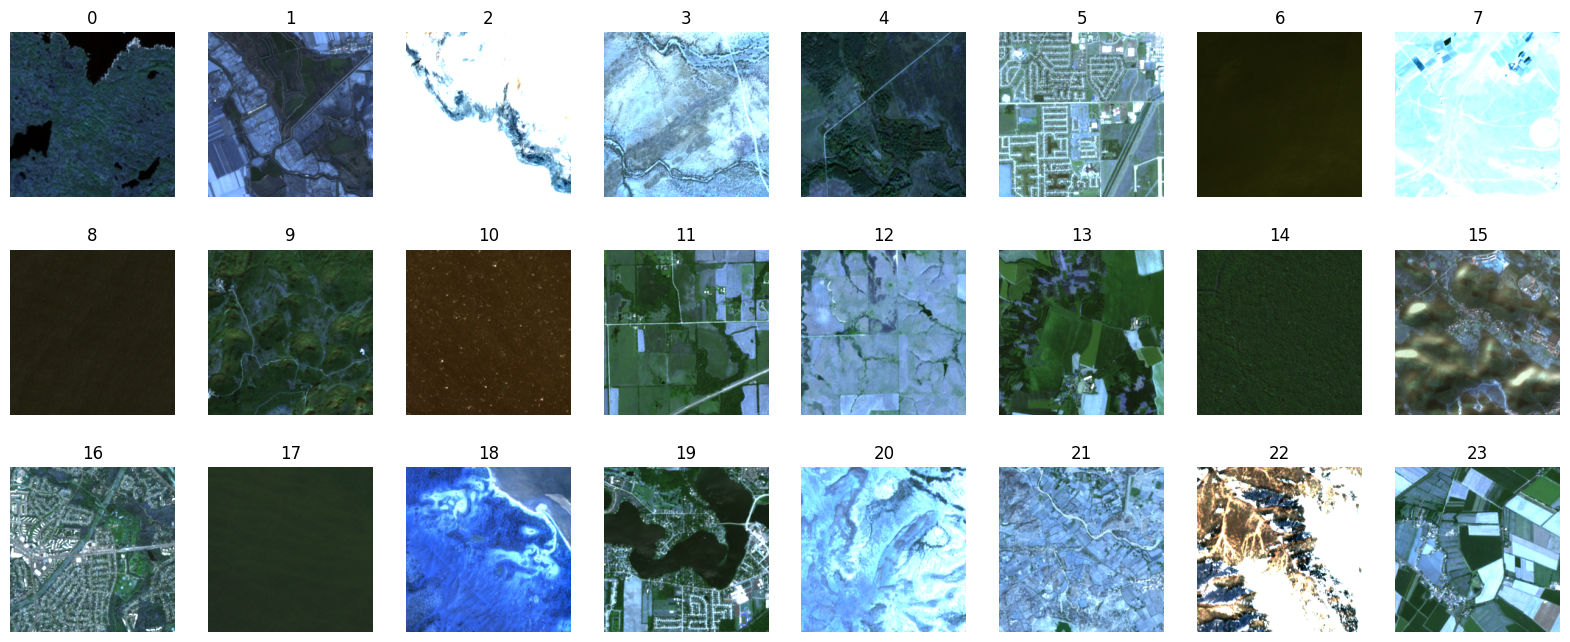

In [20]:
fig, axs = plt.subplots(3, 8, figsize=(20, 8))

for idx,ax in enumerate(axs.flatten()):
    ax.imshow(datacube_pixels[idx, :3,...].transpose(1,2,0)/2000)
    ax.set_axis_off()
    ax.set_title(idx)

In [21]:
224 // 8, 128 // 8

(28, 16)

In [23]:
unmsk_embed = rearrange(unmsk_patch[:,1:,:].detach().cpu().numpy(), 
                "b (h w) d-> b d h w", 
                h=28,
                w=28)

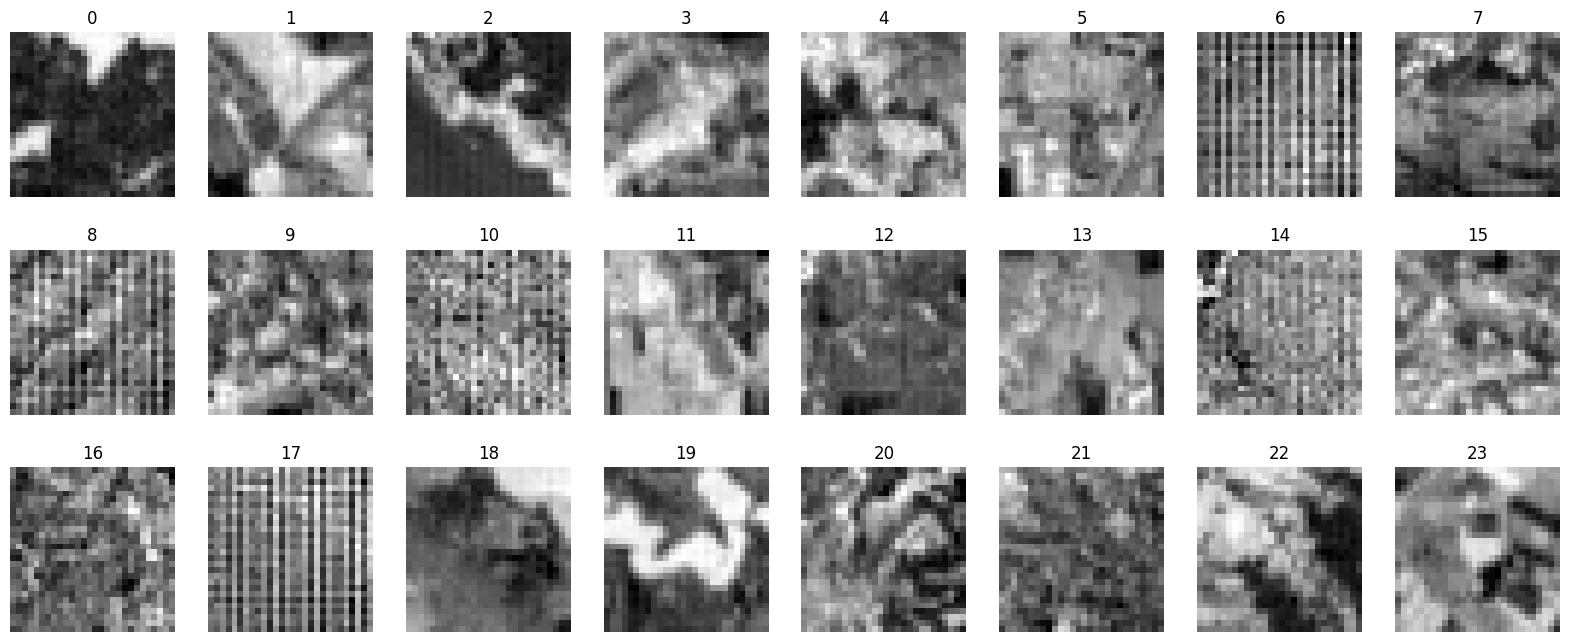

In [24]:
fig, axs = plt.subplots(3, 8, figsize=(20, 8))
embed_dim = 97
for idx,ax in enumerate(axs.flatten()):
    embed = unmsk_embed[idx]
    ax.imshow(embed[embed_dim], cmap="gray")
    ax.set_axis_off()
    ax.set_title(idx)

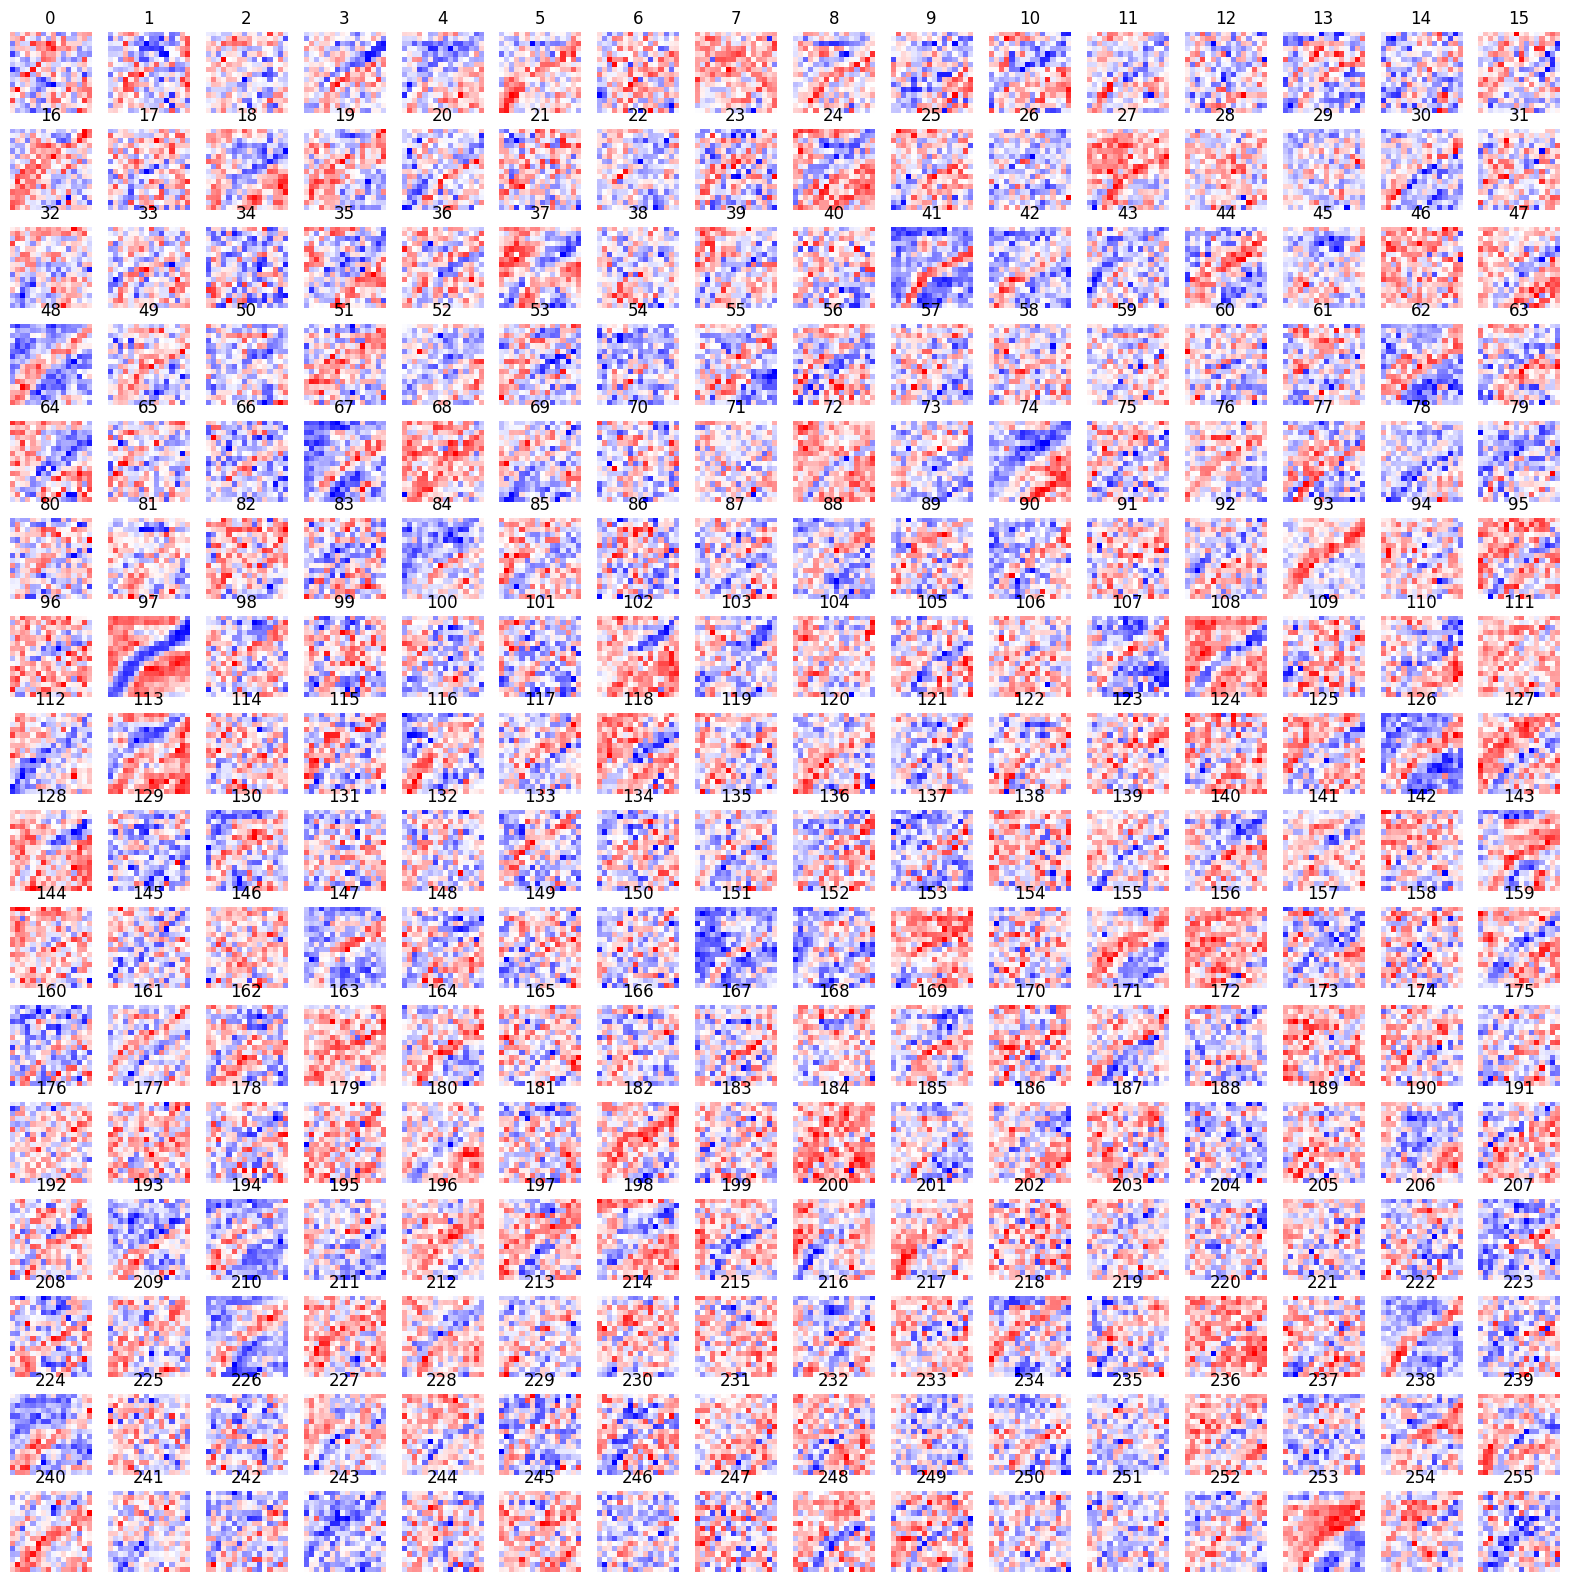

In [29]:
embed = unmsk_embed[16]
fig, axs = plt.subplots(16, 16, figsize=(20, 20))

for idx,ax in enumerate(axs.flatten()):
    ax.imshow(embed[idx], cmap="bwr")
    ax.set_axis_off()
    ax.set_title(idx)